### 4. Feature Engineering

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from imblearn.combine import SMOTEENN
df = pd.read_csv('preprocessed_dataframe.csv')
df.date_registered = pd.to_datetime(df['date_registered'])
df.head()

,student_country,date_registered,paid,num_rated_courses,avg_rated_courses,avg_course_watched,total_time_watched,engagement_quizzes,engagement_exams,engagement_lessons,avg_exam_score,no_of_questions
0,IN,2022-01-01,0,0.0,4.843363,0.300000,0.3,0.0,0.0,1.0,64.446828,0.0
1,CO,2022-01-01,0,0.0,4.843363,13.189004,0.1,0.0,0.0,1.0,64.446828,0.0
2,IN,2022-01-01,0,0.0,4.843363,13.189004,0.1,0.0,0.0,1.0,64.446828,0.0
3,US,2022-01-01,0,0.0,4.843363,13.189004,0.1,0.0,0.0,1.0,64.446828,0.0
4,BD,2022-01-01,0,0.0,4.843363,14.200000,14.2,1.0,0.0,1.0,64.446828,0.0


#### 4.1 Vectorizing student_country feature

There are 179 different countries, so using one hot encoding will create 179 different features which are too many. So, we will instead opt for label encoding, but in slightly different fashion. Here, we will replace the country name, with its count.

In [7]:
country_count_dict = df.student_country.value_counts().to_dict()
df.student_country = df.student_country.apply(lambda x : country_count_dict[x])

#with open('country_dict.pickle', 'wb') as f:
#    pickle.dump(country_count_dict,f)

d = pickle.load(open('country_dict.pickle','rb'))

#### 4.2 Handling the date_registered feature and no_of_questions

date_registered feature does not provide any valuable information that would be useful in distinguishing between a free tier user or a paid one. Therefore, it is better to drop this feature. Also, no_of_questions feature, as seen from EDA, does not provide any useful information. So, we will be dropping no_of_questions feature too.

In [4]:
df.drop(columns=['date_registered', 'no_of_questions'], inplace=True)

#### 4.3 Splitting the train and test split

In [13]:
# removing the redundancy in data. Revmoving duplicate rows of data
duplicate_indices = df[df.duplicated()].index
df = df.drop(duplicate_indices).reset_index(drop=True)

# defining the dependent and independent variables
X = df.drop(columns=['paid'])
y = df['paid']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size=.1, stratify=y)
X_train.shape,y_train.shape, X_test.shape, y_test.shape

((9831, 9), (9831,), (1093, 9), (1093,))

#### 4.4 Vectorizing the features

'avg_rated_courses' , 'avg_exam_score' these features have fixed range so these will be min-max scaled, whereas the rest of the features will be standardized. 

In [15]:
X_train.avg_exam_score = (X_train.avg_exam_score  - 0) / (100 - 0)
X_train.avg_rated_courses = (X_train.avg_rated_courses - 0)/(5-0)

X_test.avg_exam_score = (X_test.avg_exam_score - 0)/ (100-0)
X_test.avg_rated_courses = (X_test.avg_rated_courses - 0)/(5-0)

Standardizing the remaining features using standardscaler

In [16]:
scaler = StandardScaler()
standard_columns = ['student_country', 'num_rated_courses', 'avg_course_watched', 'total_time_watched', \
          'engagement_quizzes','engagement_exams', 'engagement_lessons']
scaler.fit(X_train[standard_columns])
X_train[standard_columns] = scaler.transform(X_train[standard_columns])
X_test[standard_columns] = scaler.transform(X_test[standard_columns])

X_train.reset_index(inplace=True,drop=True)
X_test.reset_index(inplace=True, drop=True)

#### 4.5 Balance the dataset

Oversampling followed by undersampling is seen to work well rather than just oversampling or just undersampling. So, we will be first oversampling the minority class and it will be followed by undersampling.

In [17]:
print(f'datasize before sampling is {X_train.shape, y_train.shape} and number of positive labels in y_train is {sum(y_train)}')
# oversampling followed by undersampling
sme = SMOTEENN(random_state=0)
X_res, y_res = sme.fit_resample(X_train, y_train)
print(f'datasize after oversampling and undersampling is {X_res.shape,y_res.shape} and number of positive labels in y_train is {sum(y_res)}')
print(f'Number of duplicate rows is {sum(X_res.duplicated())}')
# find the index of duplicate rows
indices = X_res[X_res.duplicated()].index
# find the number of positive labels in those duplicate records
print(sum(y_res[indices]))

datasize before sampling is ((9831, 9), (9831,)) and number of positive labels in y_train is 883
datasize after oversampling and undersampling is ((11775, 9), (11775,)) and number of positive labels in y_train is 6183


13

As the sum is zero, it implies that all those duplicate rows are for rows which correspond to 'unpaid' user which were already in majority. So, we can drop those rows

In [20]:
X_res = X_res.drop(indices)
y_res = y_res.drop(indices)
print(X_res.shape, y_res.shape)

(11762, 9) (11762,)


#### 4.6 Feature Selection

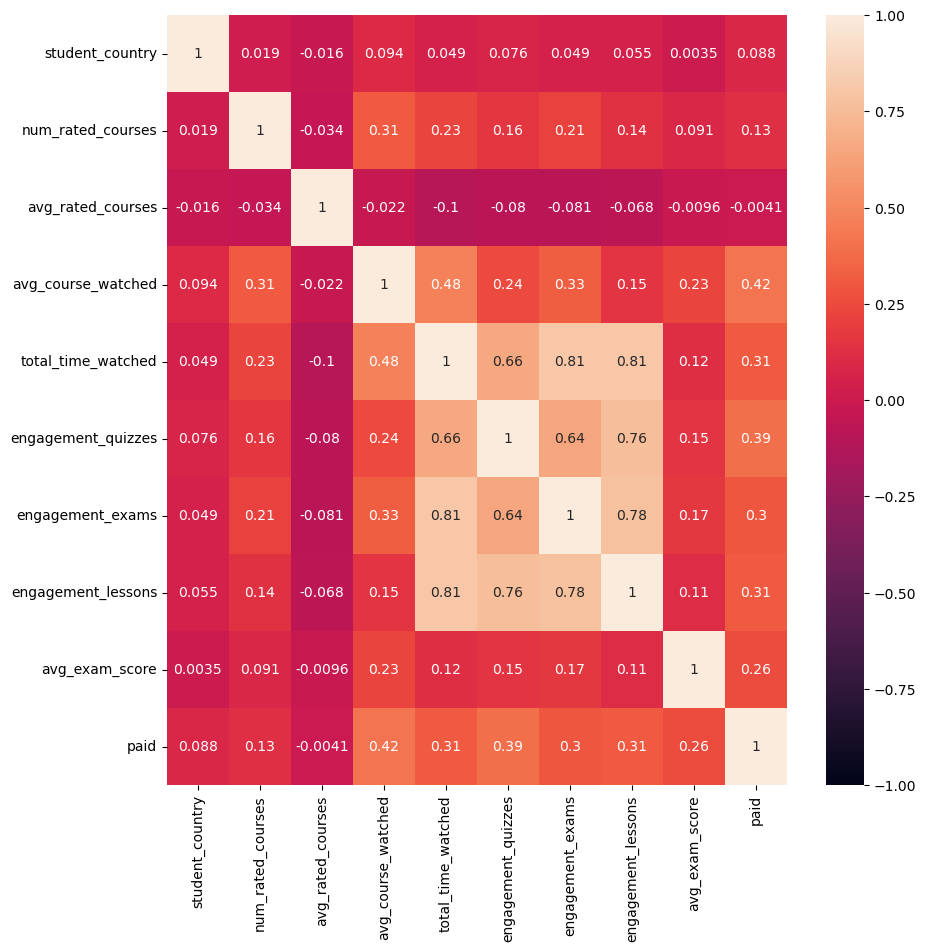

In [42]:
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(temp.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

#### Observations : 

1. Features student_countries and avg_rated_courses have very small correlation with target variable and therefore would be good idea to drop those features.
2. Feature avg_course_watched has good correlation with target feature 'paid' and does not have strong correlation with other independent features.
3. Features total_time_watched, engagement_quizzes, engagement_lessons and engagement_exams have somewaht good correlation with target feature but have similar correlation with each other too. It is very likely that selecting one of those features would give the same results as with all four of these features. Thus we can say that there is a room for improvement and we will be able to drop some features while preserving the model performance.

#### 4.7 Forward Feature Selection

In [151]:
def forward_feature_selection(X_res,y_res):
    
    # split data into train and validation set
    X_tr,X_val, y_tr, y_val = train_test_split(X_res, y_res, stratify=y_res, test_size=.1)
    
    # getting the list of all features
    features = list(X_tr.columns)

    # initializing selected features list
    selected_features = []
    num_features_auc_dict = dict() 

    # implemented forward feature selection, going through all the features one-by-one
    for num_of_features in tqdm(range(1,len(features)+1)):

        # create a copy of features selected so far
        temp_features = selected_features.copy()
        
        # dictionary to store auc scores of all the features 
        auc_dict = dict()

        for feature in features :

            temp_features.append(feature)
            temp_tr = X_tr[temp_features]
            temp_val = X_val[temp_features]
            
            # define classifier
            classifier = SGDClassifier(loss='log_loss', random_state=0)
            classifier.fit(temp_tr, y_tr)
            prediction = classifier.predict_proba(temp_val)
            
            auc_score = roc_auc_score(y_val, prediction[:,1])
            auc_dict[feature] = auc_score
            temp_features.remove(feature)
    
        # append the feature with maximum performance gain to the list of selected feature
        selected_feature = max(auc_dict, key=auc_dict.get)
        num_features_auc_dict[num_of_features] = (selected_feature, max(auc_dict.values()))
        features.remove(selected_feature)
        selected_features.append(selected_feature)
        
    return num_features_auc_dict
    
features_list = forward_feature_selection(X_res,np.array(y_res.values))
features_list

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.50it/s]


{1: ('total_time_watched', 0.8737992252505776),
 2: ('avg_course_watched', 0.8772589620210653),
 3: ('avg_exam_score', 0.8781912090839079),
 4: ('student_country', 0.8791002947290404),
 5: ('avg_rated_courses', 0.8789323744506402),
 6: ('engagement_exams', 0.8793869172732063),
 7: ('num_rated_courses', 0.8769983960718235),
 8: ('engagement_quizzes', 0.874609874870441),
 9: ('engagement_lessons', 0.8700905032397033)}

It is evident from the above feature values that total_time_time watched alone contributes to the majority of performance score of model. total_time_watched and avg_course_watched have high correlation among themselves as avg_course_watched is created using total_time_watched and number of courses student has enrolled in. avg_exam_score for majority of the values is the average exam score that we had used while imputing the missing values. student_country is a useful feature. So, we will narrow down to only two features i.e. total_time_watched and the student_country to predict if the student is going to convert to a paid user.

so, our final training dataset would contain only two predictive features i.e. total_time_watched and the student_country

In [153]:
# selecting total_time_watched and student_country as features
X_res = X_res[['total_time_watched', 'student_country']]
X_test = X_test[['total_time_watched', 'student_country']]

# save the data to files
#X_res.to_csv('X_train.csv', index=False)
#y_res.to_csv('y_train.csv', index=False)
#X_test.to_csv('X_test.csv', index=False)
#y_test.to_csv('y_test.csv', index=False)